<a href="https://colab.research.google.com/github/jBarrios26/SP1_ML/blob/main/tarea2/Digits_18001175.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import tensorflow as tf
import os
import json
import numpy as np
from matplotlib import pyplot as plt

print("TersorFlow version", tf.__version__ )


TersorFlow version 2.4.1


## Funciones por instructor de google labs
  Sirven para dibujar los números

  Créditos: Martin Gorner
  URL: https://colab.research.google.com/github/GoogleCloudPlatform/tensorflow-without-a-phd/blob/master/tensorflow-mnist-tutorial/keras_01_mnist.ipynb#scrollTo=hleIN5-pcr0N 

In [2]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  

# Constantes necesarias

In [3]:
BATCH_SIZE = 128
EPOCHS = 100

training_images_file   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels_file   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images_file = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels_file = 'gs://mnist-public/t10k-labels-idx1-ubyte'


# Funciones para cargar el dataset de imagenes.

In [4]:
def leer_imagen(tf_bytestring):
  imagen = tf.io.decode_raw(tf_bytestring, tf.uint8)
  imagen = tf.cast(imagen, tf.float32)/256.0
  imagen = tf.reshape(imagen, [28*28])
  return imagen

def leer_etiquetas(tf_bytestring):
  tag = tf.io.decode_raw(tf_bytestring, tf.uint8)
  tag = tf.reshape(tag, [])
  tag = tf.one_hot(tag, 10)
  return tag

def cargar_dataset(image_filename, label_filename):
  image_dataset = tf.data.FixedLengthRecordDataset(image_filename, 28*28, header_bytes=16) #Cargar el dataset de las imagenes
  image_dataset = image_dataset.map(leer_imagen, num_parallel_calls = 16) # Se lee cada imagen
  label_dataset = tf.data.FixedLengthRecordDataset(label_filename, 1, header_bytes=8) # Cargar el dataset de las etiquetas
  label_dataset = label_dataset.map(leer_etiquetas, num_parallel_calls = 16) # Se leen las etiquetas
  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)) # Se junta cada imagen con su etiqueta. (imagen, label)
  return dataset

def cargar_set_entrenamiento(image_filename, label_filename):
  dataset = cargar_dataset(image_filename, label_filename)
  dataset = dataset.cache() # Guarda el batch de imagenes en la RAM 
  dataset = dataset.shuffle(5000, reshuffle_each_iteration = True) # Mezcla las imagenen en el batch
  dataset = dataset.repeat() # Encicla el dataset
  dataset = dataset.batch(BATCH_SIZE) # Crea grupos de imagenes de tamaño 128. 
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE) # Empieza a cargar el siguiente batch mientras el actual sigue procesandose. 
  return dataset

def cargar_set_validacion(image_filename, label_filename):
  dataset = cargar_dataset(image_filename, label_filename)
  dataset = dataset.cache() # Guarda el batch de imagenes en la RAM 
  dataset = dataset.batch(10000, drop_remainder = True) # Solo un batch del tamaño completo del dataset
  dataset = dataset.repeat() # Encicla el dataset
  return dataset

set_entrenamiento = cargar_set_entrenamiento(training_images_file, training_labels_file)
set_validacion = cargar_set_validacion(validation_images_file, validation_labels_file)


# Crear el modelo: Utilizando como optimizador SGD

In [5]:
model = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(28*28, )),
                             tf.keras.layers.Dense(10, activation='softmax')
        ])

In [6]:
model.compile(optimizer='sgd',
              loss= 'categorical_crossentropy',
              metrics = 'accuracy'
              )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


#Entrenar el modelo

In [33]:
steps_per_epoch = 60000//BATCH_SIZE 
history = model.fit(set_entrenamiento, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          validation_data=set_validacion, validation_steps=1)

Epoch 1/100
468/468 [==============================] - 2s 4ms/step - loss: 0.2702 - accuracy: 0.9252 - val_loss: 0.2731 - val_accuracy: 0.9229
Epoch 2/100
468/468 [==============================] - 2s 3ms/step - loss: 0.2700 - accuracy: 0.9254 - val_loss: 0.2730 - val_accuracy: 0.9230
Epoch 3/100
468/468 [==============================] - 2s 4ms/step - loss: 0.2698 - accuracy: 0.9255 - val_loss: 0.2731 - val_accuracy: 0.9228
Epoch 4/100
468/468 [==============================] - 2s 4ms/step - loss: 0.2698 - accuracy: 0.9255 - val_loss: 0.2729 - val_accuracy: 0.9229
Epoch 5/100
468/468 [==============================] - 2s 4ms/step - loss: 0.2698 - accuracy: 0.9254 - val_loss: 0.2728 - val_accuracy: 0.9229
Epoch 6/100
468/468 [==============================] - 2s 3ms/step - loss: 0.2696 - accuracy: 0.9254 - val_loss: 0.2727 - val_accuracy: 0.9229
Epoch 7/100
468/468 [==============================] - 2s 4ms/step - loss: 0.2701 - accuracy: 0.9254 - val_loss: 0.2727 - val_accuracy: 0.9232

# Encontrar predicciones

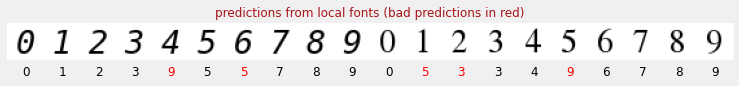

In [34]:
font_digits, font_labels = create_digits_from_local_fonts(20)
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", 20)

# Gráficas comparando el accuracy y el loss 

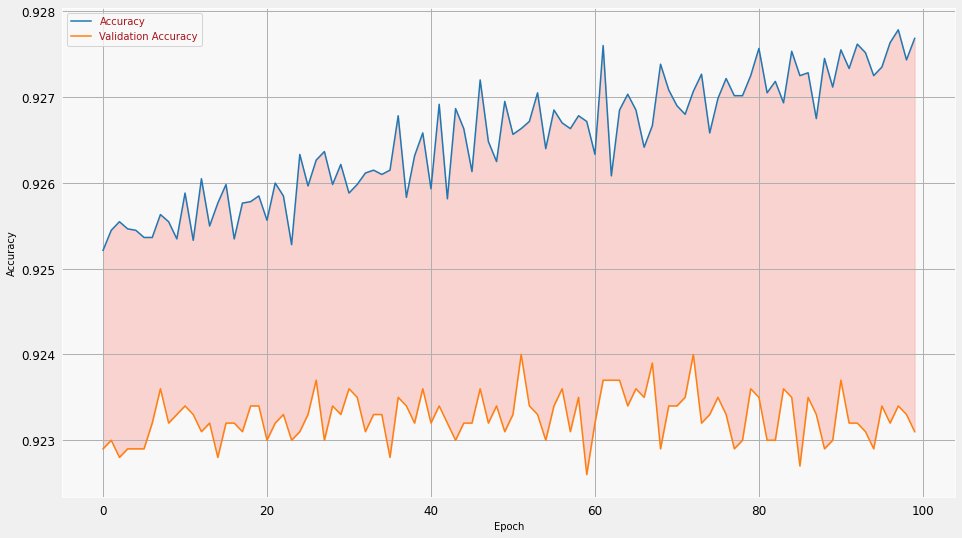

In [40]:
plt.plot(range(EPOCHS), history.history['accuracy'], label='Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.fill_between(range(EPOCHS),
                 history.history['accuracy'],
                 history.history['val_accuracy'],
                 color='salmon',
                 alpha = 0.3)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

# Crear modelo utilizando como optimizador Adam

In [14]:
adam_model = tf.keras.Sequential(
    [
     tf.keras.layers.Input(shape=(28*28,)),
     tf.keras.layers.Dense(10, activation='softmax')
    ])


In [19]:
adam_model.compile(optimizer='adam',
                   loss = 'categorical_crossentropy',
                   metrics='accuracy')

adam_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


# Entrenar el modelo

In [20]:
adam_history = adam_model.fit(set_entrenamiento, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
          validation_data=set_validacion, validation_steps=1)

Epoch 1/100
468/468 [==============================] - 2s 4ms/step - loss: 1.0539 - accuracy: 0.7259 - val_loss: 0.3853 - val_accuracy: 0.8991
Epoch 2/100
468/468 [==============================] - 2s 3ms/step - loss: 0.3771 - accuracy: 0.8991 - val_loss: 0.3213 - val_accuracy: 0.9123
Epoch 3/100
468/468 [==============================] - 2s 3ms/step - loss: 0.3258 - accuracy: 0.9109 - val_loss: 0.2973 - val_accuracy: 0.9170
Epoch 4/100
468/468 [==============================] - 2s 4ms/step - loss: 0.3002 - accuracy: 0.9166 - val_loss: 0.2862 - val_accuracy: 0.9205
Epoch 5/100
468/468 [==============================] - 2s 4ms/step - loss: 0.2864 - accuracy: 0.9203 - val_loss: 0.2777 - val_accuracy: 0.9220
Epoch 6/100
468/468 [==============================] - 2s 3ms/step - loss: 0.2785 - accuracy: 0.9220 - val_loss: 0.2752 - val_accuracy: 0.9238
Epoch 7/100
468/468 [==============================] - 2s 3ms/step - loss: 0.2717 - accuracy: 0.9242 - val_loss: 0.2706 - val_accuracy: 0.9246

# Probando el modelo

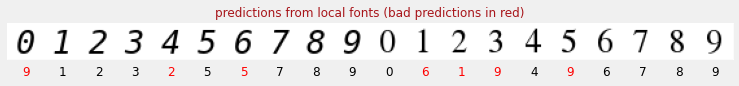

In [28]:
probabilities = adam_model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", 20)

# Visualizando el accuracy

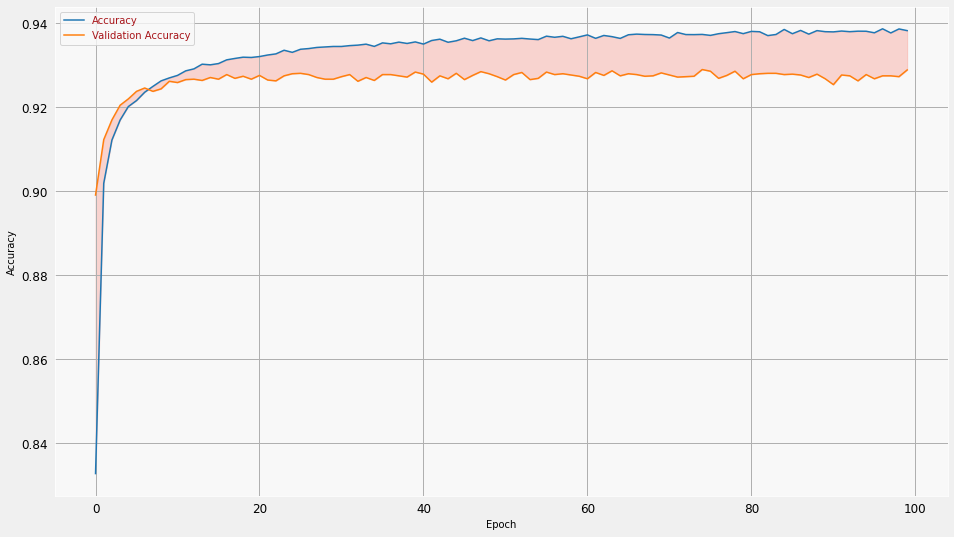

In [41]:
plt.plot(range(EPOCHS), adam_history.history['accuracy'], label='Accuracy')
plt.plot(range(EPOCHS), adam_history.history['val_accuracy'], label='Validation Accuracy')
plt.fill_between(range(EPOCHS),
                 adam_history.history['accuracy'],
                 adam_history.history['val_accuracy'],
                 color='salmon',
                 alpha = 0.3)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

# Comparando ambos modelos

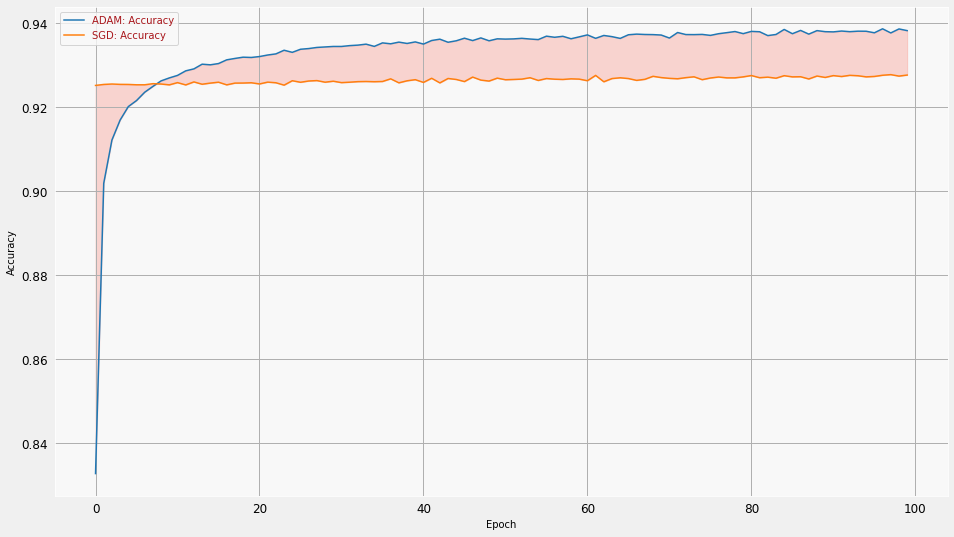

In [45]:
plt.plot(range(EPOCHS), adam_history.history['accuracy'], label='ADAM: Accuracy')
plt.plot(range(EPOCHS), history.history['accuracy'], label='SGD: Accuracy')
plt.fill_between(range(EPOCHS),
                 adam_history.history['accuracy'],
                 history.history['accuracy'],
                 color='salmon',
                 alpha = 0.3)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()

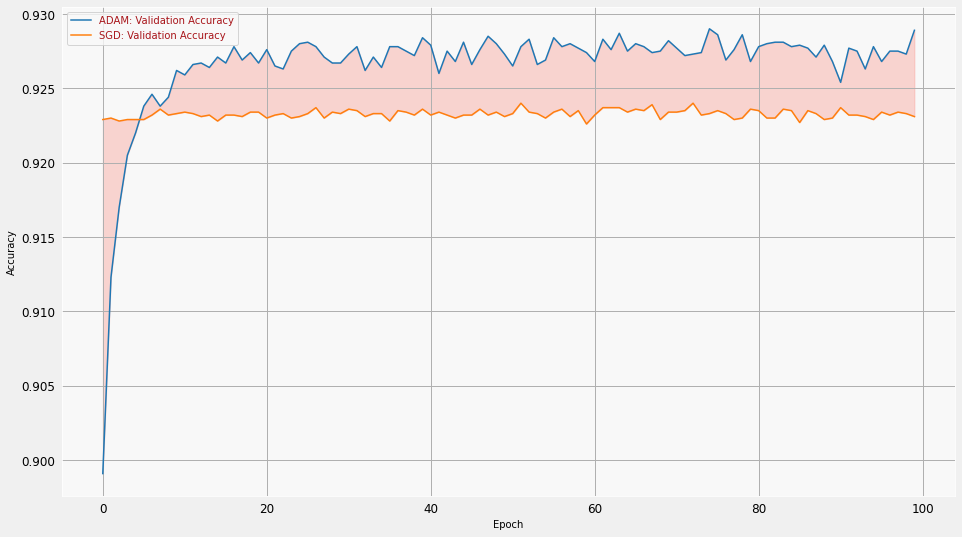

In [46]:
plt.plot(range(EPOCHS), adam_history.history['val_accuracy'], label='ADAM: Validation Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='SGD: Validation Accuracy')
plt.fill_between(range(EPOCHS),
                 adam_history.history['val_accuracy'],
                 history.history['val_accuracy'],
                 color='salmon',
                 alpha = 0.3)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.legend()
plt.show()